In [3]:
import numpy as np
import scipy.linalg as LA
"""
    Parameters:
    - H: Hamiltonian of the system (numpy array of shape (N, N)).
    - rho0: Initial density matrix (numpy array of shape (N, N)).
    - time_arr: Time array for dynamic simulation (array).
    - L: List of Collapse operators (numpy array of shape (N, N)).
    - observable: Observable for which the expectation value is computed (numpy array of shape (N, N)).
    - IsGt: Boolean variable that determines whether to output the propagator list
    Returns:
    - expec_vals: List of expectation values of the observable over time.
    """
def matrix_expo_prop(H, rho0, time_arr, L, observable, IsGt=False):
    Nsys = H.shape[0]
    ident_h = np.eye(Nsys, dtype=np.complex_)
    
    # Amatrix for time-derivation of the vectorized density matrix
    Amat = -1j * (np.kron(H, ident_h) - np.kron(ident_h, H.T))
    for i in range(len(L)):
      Amat += 0.5 * (2.0 * (np.kron(L[i], L[i].conj())) 
                           - np.kron(ident_h, L[i].T @ L[i].conj()) 
                           - np.kron(L[i].T.conj() @ L[i], ident_h))
    
    vec_rho0 = rho0.reshape(Nsys**2)
    expec_vals = []
    
    if(IsGt): G_prop = []
    for t in time_arr:
        Gt = LA.expm(Amat * t)
        if(IsGt): G_prop.append(Gt)
        vec_rhot = Gt @ vec_rho0
        rhot = vec_rhot.reshape(Nsys, Nsys)
        expec_vals.append(np.trace(rhot @ observable).real)
    
    if(IsGt): 
      return expec_vals, G_prop
    else:
      return expec_vals

In [4]:
from qutip import mesolve, Qobj

def qutip_prop(H, rho0, time_arr, c_ops, observable):
    """
    First import the mesolve function, which is used to solve master equations, and the Qobj class, which is used to represent quantum objects, from the QuTiP library.
    - H: Hamiltonian of the system (Qobj).
    - rho0: Initial density matrix (Qobj).
    - time_arr: Time array for dynamic simulation (array).
    - c_ops: List of collapse operators (list of Qobj), can be empty for Liouville equation.
    - observable: Operator for which the expectation value is to be calculated (Qobj).
    Returns:
    - expec_vals: List of expectation values of the observable over time.
    """
    result = mesolve(H, rho0, time_arr, c_ops, observable)
    return result.expect

In [5]:
# Pauli matrices
sigmax = np.array([[0, 1], [1, 0]], dtype=np.complex_)
sigmaz = np.array([[1, 0], [0, -1]], dtype=np.complex_)
sigmay = np.array([[0, -1j], [1j, 0]], dtype=np.complex_)
ident = np.eye(2, dtype=np.complex_)

# Spin-up and spin-down states
spin_up = np.array([1.0, 0.0], dtype=np.float_)
spin_down = np.array([0.0, 1.0], dtype=np.float_)

# The Spin-1/2 system Hamiltonian
H_1spin = 2 * np.pi * 0.1 * sigmax

# The jump operator and damping rate of Spin-1/2 system
gamma_1spin = 0.05
L_1spin = np.sqrt(gamma_1spin)*sigmax.copy()

# Initial density matrix
rho0_1spin = np.outer(spin_up, spin_up.conj())

# Time step and number of steps
dt = 0.1
nsteps = 250
time_arr = np.linspace(0, (nsteps - 1) * dt, nsteps)

# Matrix Exponential Propagation
expec_vals_matrix_exp = matrix_expo_prop(H_1spin, rho0_1spin, time_arr, [L_1spin], sigmaz)

# QuTiP Propagation for Liouville equation (no collapse operator)
expec_vals_qutip_Liouv = qutip_prop(Qobj(H_1spin), Qobj(rho0_1spin), time_arr, [], Qobj(sigmaz))

# QuTiP Propagation for Lindblad equation
expec_vals_qutip_Lindblad = qutip_prop(Qobj(H_1spin), Qobj(rho0_1spin), time_arr, [Qobj(L_1spin)], Qobj(sigmaz))

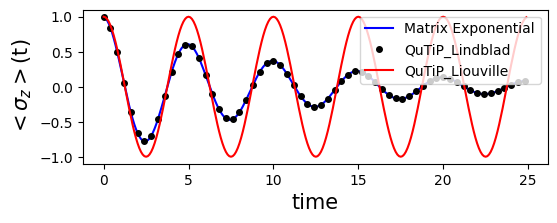

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,2))
plt.plot(time_arr, expec_vals_matrix_exp,'b-', label = "Matrix Exponential")
plt.plot(time_arr, expec_vals_qutip_Lindblad[0],'ko',markersize=4,markevery=4, label = "QuTiP_Lindblad")
plt.plot(time_arr, expec_vals_qutip_Liouv[0],'r-', label = "QuTiP_Liouville")
plt.xlabel('time',fontsize=15)
plt.ylabel('$<\\sigma_z>$(t)',fontsize=15)
plt.legend(loc = 'upper right')
plt.show()